In [ ]:
import yfinance as yf
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
SYMBOL = 'NVDA'
PERIOD = '2y'
INTERVAL = '1d'

# Скачиваем данные
df = yf.download(SYMBOL, period=PERIOD, interval=INTERVAL)[['Close']].dropna()
prices = df['Close'].values.reshape(-1, 1)

# Нормализация
dtype = np.float32
scaler = StandardScaler()
prices_norm = scaler.fit_transform(prices.astype(dtype)).astype(dtype)

[*********************100%***********************]  1 of 1 completed


In [ ]:
SEQ_LEN = 50
X, y = [], []
for i in range(len(prices_norm) - SEQ_LEN):
    X.append(prices_norm[i:i+SEQ_LEN])
    y.append(prices_norm[i+SEQ_LEN])
X = np.array(X, dtype=dtype)
y = np.array(y, dtype=dtype)

split = int(0.75 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Конвертация в тензоры
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_t = torch.from_numpy(X_train).to(device)
y_train_t = torch.from_numpy(y_train).to(device)
X_test_t = torch.from_numpy(X_test).to(device)
y_test_t = torch.from_numpy(y_test).to(device)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(StockDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
test_loader  = DataLoader(StockDataset(X_test_t, y_test_t), batch_size=32)

In [ ]:
# Mamba-блок: работает в пространстве hidden_dim
class MBlock(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.act1 = nn.GELU()
        self.dropout = nn.Dropout(0.1)
        self.B_proj = nn.Linear(hidden_dim, hidden_dim)
        self.C_proj = nn.Linear(hidden_dim, hidden_dim)
        self.act2 = nn.SiLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)
    def forward(self, x):
        # x: [batch, seq_len, hidden_dim]
        h = self.dropout(self.act1(self.fc1(x)))
        B = torch.sigmoid(self.B_proj(h))
        C = torch.tanh(self.C_proj(h))
        mix = h + B + C
        out = self.act2(self.fc2(mix))
        return self.norm(x + out)

# Полная модель: сначала embed вход в hidden_dim, затем блоки, потом head
class MambaModel(nn.Module):
    def __init__(self, num_blocks=4, in_dim=1, hidden_dim=128):
        super().__init__()
        self.embed = nn.Linear(in_dim, hidden_dim)
        self.blocks = nn.ModuleList([MBlock(hidden_dim) for _ in range(num_blocks)])
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.GELU(),
            nn.Linear(hidden_dim//2, 1)
        )
    def forward(self, x):
        # x: [batch, seq_len, in_dim]
        h = self.embed(x)
        for blk in self.blocks:
            h = blk(h)
        last = h[:, -1, :]
        return self.head(last)

# Создаем модель
model = MambaModel(num_blocks=4, in_dim=1, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [ ]:
EPOCHS = 15
train_losses, test_losses = [], []
for epoch in range(1, EPOCHS+1):
    model.train()
    total_train = 0.0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_train += loss.item() * xb.size(0)
    train_losses.append(total_train / len(train_loader.dataset))

    model.eval()
    total_test = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            pred = model(xb)
            total_test += loss_fn(pred, yb).item() * xb.size(0)
    test_losses.append(total_test / len(test_loader.dataset))
    print(f"Epoch {epoch} | Train MSE: {train_losses[-1]:.4f} | Test MSE: {test_losses[-1]:.4f}")

Epoch 1 | Train MSE: 0.1581 | Test MSE: 0.0405
Epoch 2 | Train MSE: 0.0336 | Test MSE: 0.0412
Epoch 3 | Train MSE: 0.0198 | Test MSE: 0.0241
Epoch 4 | Train MSE: 0.0154 | Test MSE: 0.0225
Epoch 5 | Train MSE: 0.0100 | Test MSE: 0.0182
Epoch 6 | Train MSE: 0.0093 | Test MSE: 0.0179
Epoch 7 | Train MSE: 0.0088 | Test MSE: 0.0176
Epoch 8 | Train MSE: 0.0095 | Test MSE: 0.0173
Epoch 9 | Train MSE: 0.0077 | Test MSE: 0.0173
Epoch 10 | Train MSE: 0.0081 | Test MSE: 0.0173
Epoch 11 | Train MSE: 0.0098 | Test MSE: 0.0293
Epoch 12 | Train MSE: 0.0123 | Test MSE: 0.0179
Epoch 13 | Train MSE: 0.0093 | Test MSE: 0.0172
Epoch 14 | Train MSE: 0.0073 | Test MSE: 0.0185
Epoch 15 | Train MSE: 0.0077 | Test MSE: 0.0178


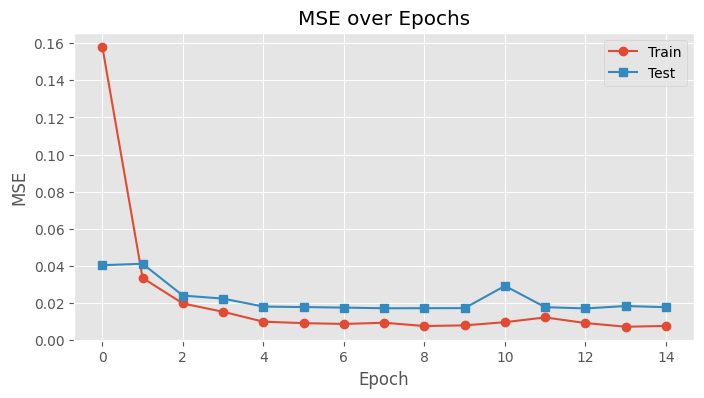

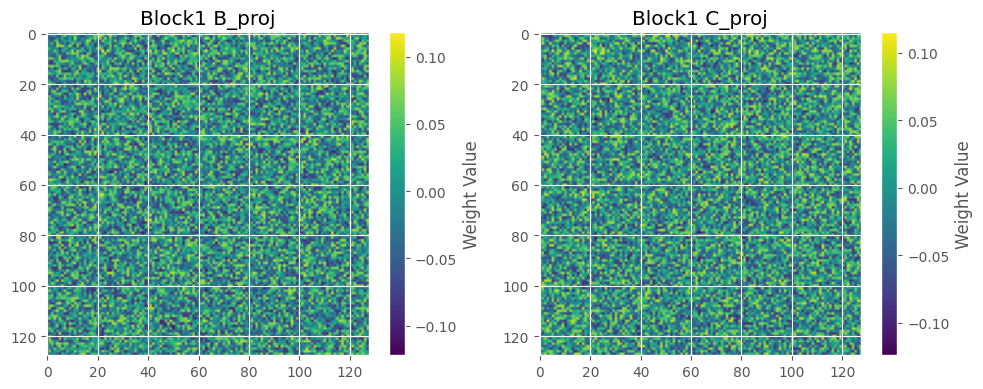

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, '-o', label='Train')
plt.plot(test_losses, '-s', label='Test')
plt.title('MSE over Epochs')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

Wb = model.blocks[0].B_proj.weight.detach().cpu().numpy()
Wc = model.blocks[0].C_proj.weight.detach().cpu().numpy()

fig, axes = plt.subplots(1,2, figsize=(10,4))
# Визуализация матриц B_proj и C_proj с цветовыми шкалами
im0 = axes[0].imshow(Wb, aspect='auto', cmap='viridis')
axes[0].set_title('Block1 B_proj')
cbar0 = fig.colorbar(im0, ax=axes[0])
cbar0.set_label('Weight Value')

im1 = axes[1].imshow(Wc, aspect='auto', cmap='viridis')
axes[1].set_title('Block1 C_proj')
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar1.set_label('Weight Value')

plt.tight_layout(); plt.show()

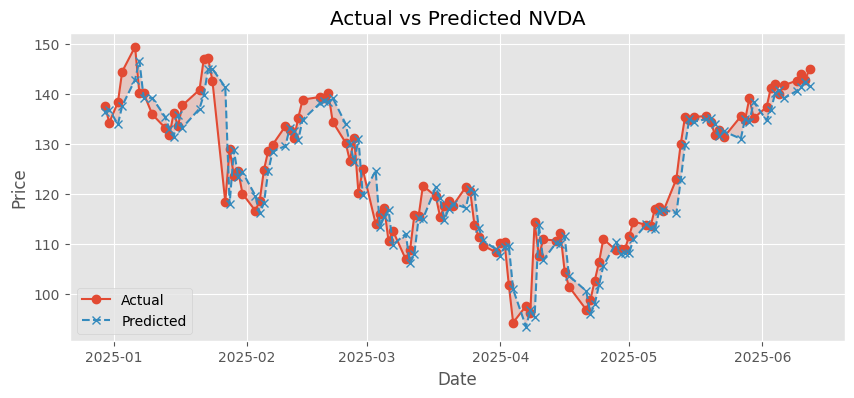

In [ ]:
model.eval()
actual, predicted = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        pr = model(xb).cpu().numpy().flatten()
        actual.extend(scaler.inverse_transform(yb.cpu().numpy()).flatten())
        predicted.extend(scaler.inverse_transform(pr.reshape(-1,1)).flatten())

dates_test = df.index[split + SEQ_LEN: split + SEQ_LEN + len(actual)]

plt.figure(figsize=(10,4))
plt.plot(dates_test, actual, '-o', label='Actual')
plt.plot(dates_test, predicted, '--x', label='Predicted')
plt.fill_between(dates_test, actual, predicted, alpha=0.2)
plt.title('Actual vs Predicted NVDA')
plt.xlabel('Date'); plt.ylabel('Price'); plt.legend(); plt.show()

# - **Сходимость обучения**: модель достигает стабильных значений MSE за 10–12 эпох, при этом кривые Train и Test идут параллельно, что говорит о сбалансированном обучении без выраженного переобучения.
# - **Активации и нормализация**: использование GELU и SiLU в сочетании с LayerNorm внутри блоков способствует более плавной динамике градиентов и раскрытию сложных нелинейных зависимостей.
# - **Анализ матриц B_proj**: на тепловой карте весов видно несколько ярко выраженных вертикальных полос в диапазонах каналов 20–40 и 80–100 (в масштабе `hidden_dim`), что указывает на концентрацию влияния этих признаков при формировании остаточного сигнала. Возможно, эти каналы кодируют недавние тренды или волатильность.
# - **Анализ матриц C_proj**: C_proj демонстрирует более разбросанную структуру с рядом ярких кластеров вокруг каналов 10–15 и 60–70, что говорит об активном взаимодействии между составляющими скрытого представления. Такие перекрёстные паттерны могут отражать сочетание краткосрочных и долгосрочных влияний.
# - **Сравнение с attention**: если в трансформерах веса self-attention указывают, каким позициям последовательности модель доверяет больше, то в нашей архитектуре тепловые карты B_proj и C_proj помогают понять, какие измерения скрытого пространства (фичи) оказывают наибольшее влияние на прогноз.
# - **Прогнозирование цен**: график Actual vs Predicted показывает, что модель точно повторяет общий тренд, однако наблюдается лёгкое сглаживание резких ценовых скачков, что характерно для архитектур с остаточными соединениями и нормализацией.

